# Running HMETS using NRCAN forcing data

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare NRCAN daily data for Canadian catchments.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
#url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

# THIS CHANGED TO REFLECT MASTER, NOT LATEST RELEASE!
url="http://localhost:9099" 

wps = WPSClient(url)

In [2]:
# SETUP THE RUN PARAMETERS, for now only the start and end years of the simulation, the rest is hard-coded to 
# the Salmon-river example

startYear=2007 # Year of the beginning of the simulation
endYear=2008 # Year of the end of the simulation


In [3]:
# Define the NRCAN data URLs for the OPeNDAP netCDF files
tasmax_urlBase='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/tasmax/nrcan_canada_daily_tasmax_'
tasmin_urlBase = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/tasmin/nrcan_canada_daily_tasmin_'
precip_urlBase = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/pr/nrcan_canada_daily_pr_'


In [4]:
# Get information on the Salmon catchment from our test database. This will need to be changed to allow other data
salmon=xr.open_dataset(TESTDATA['raven-hmets-nc-ts'])
salmon_lat = salmon.lat.values[0]
salmon_lon = salmon.lon.values[0]

In [5]:
# Write file path for input data
dirpath = os.getcwd()
filepath = dirpath + "/NRCAN_ts.nc"


In [6]:
"""Return a netCDF file with daily NRCAN data at the Salmon location."""
# Get first year of data. 
## NOTE THAT HERE, THE ONLY METHOD IS THE NEAREST POINT, WHEREAS WE WILL NEED TO HAVE A MORE USEFUL METHOD SUCH AS AVERAGE OF CATCHMENT POLYGON

firstYear=str(startYear)
tmaxYear=xr.open_dataset(tasmax_urlBase + firstYear + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')
tminYear=xr.open_dataset(tasmin_urlBase + firstYear + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')
prYear=xr.open_dataset(precip_urlBase + firstYear + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')


In [7]:
# Now extract all following years. It might take a few minutes depending on the number of years
# that are fetched through the server. 
## ALSO THE SAME LIMITATION RELATED TO THE NEAREST POINT vs AVERAGE OF POINTS WITHIN CONTOUR (or Thiessen, inverse distance weighting, etc.)
for i in range(startYear+1,endYear+1):
        
    tmaxYear=xr.concat([tmaxYear,xr.open_dataset(tasmax_urlBase + str(i) + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')],dim='time')
    tminYear=xr.concat([tminYear,xr.open_dataset(tasmin_urlBase + str(i) + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')],dim='time')
    prYear=xr.concat([prYear,xr.open_dataset(precip_urlBase + str(i) + '.nc').sel(lon=salmon_lon, lat=salmon_lat, method='nearest')],dim='time')
     

In [8]:
# Now we need to merge precip, tasmax and tasmin variables into one NetCDF file, and write to disk for future use.
main=tmaxYear.merge(tminYear,compat='override')
main=main.merge(prYear,compat='override')
main.to_netcdf(filepath)


In [9]:
# Finally, adjust the time units

# IT SEEMS THIS IS NEEDED IN PYTEST TESTS BUT NOT HERE?! IF I UNCOMMENT THIS, YEARS ARE 1900-01-01 to 1902-12-31...

D = nc.Dataset(filepath, "a")
D.variables["time"].units = "days since " + str(startYear) + "-01-01 00:00:00"
D.close()     
D = nc.Dataset(filepath, "r+")
D.variables["time"] = list(range(0,D.variables["tasmax"].shape[0]))
D.close() 

In [12]:
import json
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
            '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Forcing files: Let's use the file we just created
ts=filepath

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2007, 5, 1),
    end_date=dt.datetime(2007, 6, 30),
    area=4250.6,
    elevation=843.0,
    latitude=salmon_lat,
    longitude=salmon_lon,
    run_name='test_hmets_NRCAN',
    rain_snow_fraction='RAINSNOW_DINGMAN', # <----- ##### THIS FAILS! NEED HELP HERE! ######
    nc_spec=json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})  
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(ts), params=params, **config)


In [13]:

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [14]:
print(diagnostics)

:TimeStamp 2007-06-30 00:00:00.00
:HRUStateVariableTable
  :Attributes,SURFACE_WATER,ATMOSPHERE,ATMOS_PRECIP,PONDED_WATER,SOIL[0],SOIL[1],SNOW,SNOW_LIQ,CUM_SNOWMELT,CONVOLUTION[0],CONVOLUTION[1],AET,CONV_STOR[0],CONV_STOR[1],CONV_STOR[2],CONV_STOR[3],CONV_STOR[4],CONV_STOR[5],CONV_STOR[6],CONV_STOR[7],CONV_STOR[8],CONV_STOR[9],CONV_STOR[10],CONV_STOR[11],CONV_STOR[12],CONV_STOR[13],CONV_STOR[14],CONV_STOR[15],CONV_STOR[16],CONV_STOR[17],CONV_STOR[18],CONV_STOR[19],CONV_STOR[20],CONV_STOR[21],CONV_STOR[22],CONV_STOR[23],CONV_STOR[24],CONV_STOR[25],CONV_STOR[26],CONV_STOR[27],CONV_STOR[28],CONV_STOR[29],CONV_STOR[30],CONV_STOR[31],CONV_STOR[32],CONV_STOR[33],CONV_STOR[34],CONV_STOR[35],CONV_STOR[36],CONV_STOR[37],CONV_STOR[38],CONV_STOR[39],CONV_STOR[40],CONV_STOR[41],CONV_STOR[42],CONV_STOR[43],CONV_STOR[44],CONV_STOR[45],CONV_STOR[46],CONV_STOR[47],CONV_STOR[48],CONV_STOR[49],CONV_STOR[50],CONV_STOR[51],CONV_STOR[52],CONV_STOR[53],CONV_STOR[54],CONV_STOR[55],CONV_STOR[56],CONV_STOR[57]

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [15]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 61, nbasins: 1)>
array([[  0.      ],
       [170.910938],
       [341.303273],
       [337.880894],
       [331.668788],
       [325.355314],
       [320.107972],
       [316.905823],
       [313.257583],
       [307.852679],
       [302.402846],
       [296.921615],
       [291.403803],
       [285.84618 ],
       [280.274321],
       [274.744343],
       [269.326396],
       [264.085853],
       [260.506351],
       [260.229066],
       [258.657852],
       [254.423934],
       [250.529712],
       [246.783187],
       [243.298359],
       [239.895463],
       [236.692347],
       [233.409737],
       [229.869419],
       [226.352526],
       [222.865621],
       [219.438253],
       [216.088097],
       [212.822756],
       [209.642902],
       [208.251135],
       [213.454126],
       [217.778198],
       [215.607062],
       [212.556563],
       [211.015082],
       [211.687364],
       [210.75523 ],
       [207.622251],
       [205.47791 ],
     

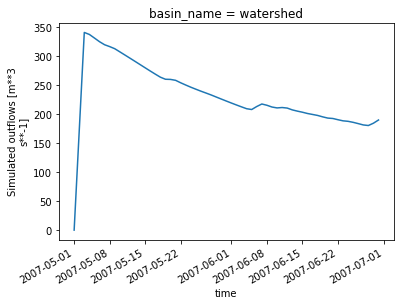

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [6]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(338.27670973)
Mean:  <xarray.DataArray 'q_sim' ()>
array(114.21520508)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[145.47625261],
       [100.23013979],
       [ 72.54535855],
       [100.5531725 ],
       [158.08129744],
       [131.89812816],
       [132.25412379],
       [129.30157554],
       [122.49175427],
       [104.23439113],
       [108.01578307],
       [ 64.06515605]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
